In [1]:
# TD3 on Pendulum (was DDPG, but it's really painful to make stable)
# It is the same algorithm, but with three tricks.
# https://spinningup.openai.com/en/latest/algorithms/td3.html

In [2]:
%pylab inline
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import gym
import time
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Dense, Activation
import random

Populating the interactive namespace from numpy and matplotlib


In [3]:
env = gym.make("Pendulum-v0")
env.observation_space, env.action_space, type(env.action_space)

(Box(3,), Box(1,), gym.spaces.box.Box)

In [4]:
# critic
x = in1 = Input((4,))
x = Dense(32)(x)
x = Activation('elu')(x)
x = Dense(64)(x)
x = Activation('elu')(x)
x = Dense(1)(x)
q1 = Model(in1, x)
q2 = clone_model(q1)
q1.compile(Adam(1e-3, decay=1e-6, clipnorm=1.), 'mse')
q2.compile(Adam(1e-3, decay=1e-6, clipnorm=1.), 'mse')
q1.summary()

qf = K.function(q1.layers[0].input, q1.layers[-1].output)

# actor
x = in1 = Input((3,))
x = Dense(32)(x)
x = Activation('elu')(x)
x = Dense(64)(x)
x = Activation('elu')(x)
x = Dense(1)(x)
p = Model(in1, x)
def loss(y_true, y_pred):
  qfi = tf.concat([in1, y_pred], axis=1)
  # this will not update the weights in q
  loss = -qf._graph_fn(qfi)[0]
  return loss
p.compile(Adam(1e-3, decay=1e-6, clipnorm=1.), loss)
p.summary()

lll = []
D = []
gamma = 0.99
polyak = 0.995

pf = K.function(p.layers[0].input, p.layers[-1].output)

q1arg = clone_model(q1)
q2arg = clone_model(q2)
parg = clone_model(p)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
___________________________________________________________

In [5]:
def UONoise(theta=0.15, sigma=0.2):
  state = 0
  while True:
    yield state
    state += -theta*state + sigma*np.random.randn()

for epoch in range(500):
  D = D[-100000:]
  st = time.perf_counter()
  
  noise = UONoise()
  obs = env.reset()
  rews = []
  while True:
    if len(D) < 10000:
      # random exploration
      act = np.random.uniform(env.action_space.low, env.action_space.high)
    else:
      # pick action
      act = pf(obs[None])[0]
      act += next(noise)  # exploration noise, temporally correlated
    act = np.array(np.clip(act, env.action_space.low, env.action_space.high))

    # save this state action pair
    s = np.copy(obs)
    # take the action and save the reward
    obs, rew, done, _ = env.step(act)
    rews.append(rew)

    D.append((s, act, rew, np.copy(obs), int(done)))
    if done:
      break
  
  pl, ql1, ql2 = 0,0,0
  if len(D) > 10000:
    for j in range(25):
      # update time
      B = random.choices(D, k=1024)
      s = np.array([x[0] for x in B])
      a = np.array([x[1] for x in B])
      r = np.array([x[2] for x in B])
      sp = np.array([x[3] for x in B])
      d = np.array([x[4] for x in B])

      # get ap and targets
      ap = parg.predict_on_batch(sp)
      ap += np.random.normal(0, 0.1, size=ap.shape)
      ap = np.array(np.clip(ap, env.action_space.low, env.action_space.high))
      
      q_next1 = q1arg.predict_on_batch(np.concatenate([sp, ap], axis=1))[:, 0]
      q_next2 = q2arg.predict_on_batch(np.concatenate([sp, ap], axis=1))[:, 0]
      q_next = np.array([min(x[0], x[1]) for x in zip(q_next1, q_next2)])
      targets = r + gamma*(1-d)*q_next

      # train nets
      ql1 = q1.train_on_batch(np.concatenate([s, a], axis=1), targets.reshape((-1, 1)))
      ql2 = q2.train_on_batch(np.concatenate([s, a], axis=1), targets.reshape((-1, 1)))
      
      if j%2 == 0:
        pl = p.train_on_batch(s, a)

        # async update
        for m,marg in ((p,parg),(q1,q1arg),(q2,q2arg)):
          for l,larg in zip(m.layers, marg.layers):
            for w,warg in zip(l.weights, larg.weights):
              warg.assign(polyak*warg + (1-polyak)*w)

  lll.append((epoch, np.sum(rews), pl, ql1, ql2, len(D), time.perf_counter() - st))
  if epoch%10 == 0:
    print("%3d  ep_rew:%9.2f  pl:%7.2f  ql1:%7.2f  ql2:%7.2f  Ds: %6d  tm: %.2f s" % lll[-1])

  0  ep_rew: -1577.33  pl:   0.00  ql1:   0.00  ql2:   0.00  Ds:    200  tm: 0.02 s
 10  ep_rew: -1502.35  pl:   0.00  ql1:   0.00  ql2:   0.00  Ds:   2200  tm: 0.01 s
 20  ep_rew: -1743.29  pl:   0.00  ql1:   0.00  ql2:   0.00  Ds:   4200  tm: 0.02 s
 30  ep_rew: -1060.99  pl:   0.00  ql1:   0.00  ql2:   0.00  Ds:   6200  tm: 0.01 s
 40  ep_rew:  -963.68  pl:   0.00  ql1:   0.00  ql2:   0.00  Ds:   8200  tm: 0.01 s
 50  ep_rew: -1207.59  pl:   1.14  ql1:  32.05  ql2:  29.97  Ds:  10200  tm: 2.22 s
 60  ep_rew: -1816.66  pl:   7.40  ql1:   0.54  ql2:   0.62  Ds:  12200  tm: 0.31 s
 70  ep_rew: -1816.51  pl:  10.69  ql1:   0.25  ql2:   0.30  Ds:  14200  tm: 0.31 s
 80  ep_rew: -1438.80  pl:  13.99  ql1:   0.28  ql2:   0.37  Ds:  16200  tm: 0.31 s
 90  ep_rew: -1455.59  pl:  17.64  ql1:   0.80  ql2:   0.86  Ds:  18200  tm: 0.31 s
100  ep_rew: -1472.00  pl:  20.90  ql1:   1.06  ql2:   1.10  Ds:  20200  tm: 0.31 s
110  ep_rew: -1498.29  pl:  25.75  ql1:   2.89  ql2:   2.96  Ds:  22200  tm:

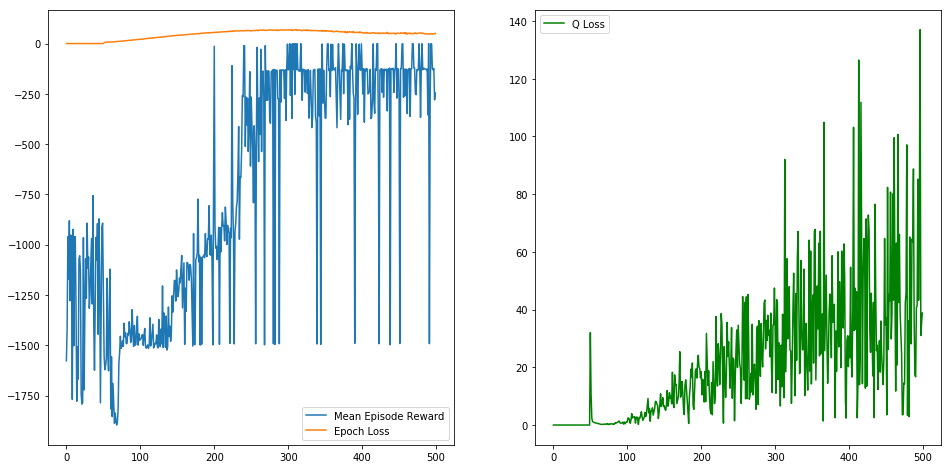

In [6]:
figsize(16,8)
plt.subplot(1,2,1)
plot([x[1] for x in lll], label="Mean Episode Reward")
plot([x[2] for x in lll], label="Epoch Loss")
plt.legend()
plt.subplot(1,2,2)
plot([x[3] for x in lll], color='green', label="Q Loss")
plt.legend()

In [7]:
obs = env.reset()
for i in range(100):
  env.render()
  act = pf(obs[None])[0]
  act = np.array(np.clip(act, env.action_space.low, env.action_space.high))
  obs, rew, done, _ = env.step(act)
  #print(i, act, rew)
  time.sleep(0.1)
  if done:
    break